In [49]:
! pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 68.2 MB/s eta 0:00:00


In [60]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...


True

In [1]:
import pandas as pd
from google.cloud import storage
from google.cloud import storage
import pandas as pd
from io import BytesIO
from google.cloud import bigquery
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import RobustScaler
%run functions.ipynb

### ------------------------------------------------
### Inserire Data Exploration Andrea
### ------------------------------------------------

In [ ]:

# Your GCS bucket name
bucket_name = 'ccai-storage'

# Paths to the Parquet files in your GCS bucket
articles_parquet_path = 'pipeline/articlesoutput.parquet'

# Initialize the GCS client
client = storage.Client()

# Function to download a Parquet file from GCS and load it into a pandas DataFrame
def load_parquet_from_gcs(bucket_name, file_path):
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(file_path)
    byte_stream = BytesIO()
    blob.download_to_file(byte_stream)
    byte_stream.seek(0)
    df = pd.read_parquet(byte_stream, engine='pyarrow')
    return df

# Load the Parquet files
articles_df = load_parquet_from_gcs(bucket_name, articles_parquet_path)

# Print the DataFrames to check their contents
#print("Articles DataFrame:")
#print(articles_df.head(2), "\n")  # Prints the first few rows

# Count the number of rows in each DataFrame
num_articles = articles_df.shape[0]
print(f"Number of articles: {num_articles}")

# Find duplicates based on the 'uri' field in articles DataFrame
duplicate_articles = articles_df[articles_df.duplicated(['uri'], keep=False)]
print(f"Number of duplicate articles based on 'uri': {duplicate_articles.shape[0]}")

# Assess min and max dates in the articles DataFrame
if not articles_df.empty:
    articles_df['date'] = pd.to_datetime(articles_df['date'])  # Ensure 'date' column is datetime type
    min_date = articles_df['date'].min()
    max_date = articles_df['date'].max()


In [3]:
# Extract the year and month components
articles_df['date_column'] = pd.to_datetime(articles_df['date'], errors='coerce') 
articles_df['year'] = articles_df['date_column'].dt.year
articles_df['month'] = articles_df['date_column'].dt.month

In [4]:
# Get the unique values of years and months
# Concatenate year and month into a single column
articles_df['year_month'] = articles_df['year'].astype(str) + '-' + articles_df['month'].astype(str)

# Get the unique combinations of year and month
unique_year_month = articles_df['year_month'].unique()

print("Unique Year-Month Combinations:", unique_year_month)

Unique Year-Month Combinations: ['2016-12' '2016-11' '2016-10' '2016-9' '2016-8' '2016-7' '2016-6'
 '2016-5' '2016-4' '2016-3' '2016-2' '2016-1' '2023-7' '2023-6' '2023-5'
 '2023-4' '2023-3' '2023-2' '2023-1' '2015-12' '2015-11' '2015-10'
 '2015-9' '2015-8' '2015-7' '2015-6' '2015-5' '2015-4' '2015-3' '2015-2'
 '2015-1' '2023-11' '2023-10' '2014-12' '2014-11' '2014-10' '2014-9'
 '2014-8' '2014-7' '2014-6' '2014-5' '2014-4' '2014-3' '2014-2' '2014-1'
 '2023-12']


In [4]:
# Filter the DataFrame to keep only the observations for the year 2023
df_2023 = articles_df[articles_df['date_column'].dt.year == 2023]

In [5]:
# Drop duplicates by the 'uri' column
df_no_dups = df_2023.drop_duplicates(subset=['uri'])

# Count the occurrences of each unique value in the 'uri' column
uri_value_counts = df_no_dups['uri'].value_counts()

# Now uri_value_counts contains the counts of each unique value in the 'uri' column
print(uri_value_counts)

uri
2023-12-196653430    1
7637916849           1
7637915097           1
7637908016           1
7637906084           1
                    ..
7637881729           1
7637881660           1
7637878058           1
7637877659           1
7637876062           1
Name: count, Length: 444231, dtype: int64


In [6]:
import numpy as np

# Replace empty strings with NaN
df_no_dups.replace('', np.nan, inplace=True)

/var/tmp/ipykernel_886510/1527321666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_dups.replace('', np.nan, inplace=True)


In [7]:
nan_count = df_no_dups.isna().sum()
print("Total NaN values:", nan_count)

Total NaN values: uri                         0
url                         0
title                       4
body                        0
date                        0
time                        0
dateTime                    0
dateTimePub                 0
lang                        0
isDuplicate                 0
dataType                    0
sentiment              444231
eventUri               314005
relevance                   0
image                    3013
authors                386699
sharesFacebook              0
sourceTitle                 0
sourceLocationLabel      1540
categoryLabels         134687
categoryWeights        134687
importanceRank              0
alexaGlobalRank             0
alexaCountryRank            0
date_column                 0
year                        0
month                       0
dtype: int64


In [28]:
# Remove rows where both "title" and "authors" are NaN
df_no_dups_remov = df_no_dups.dropna(subset=['categoryLabels', 'authors'])

In [29]:
nan_count = df_no_dups_remov.isna().sum()
print("Total NaN values:", nan_count)

Total NaN values: uri                        0
url                        0
title                      0
body                       0
date                       0
time                       0
dateTime                   0
dateTimePub                0
lang                       0
isDuplicate                0
dataType                   0
sentiment              38204
eventUri               24072
relevance                  0
image                     93
authors                    0
sharesFacebook             0
sourceTitle                0
sourceLocationLabel      228
categoryLabels             0
categoryWeights            0
importanceRank             0
alexaGlobalRank            0
alexaCountryRank           0
date_column                0
year                       0
month                      0
dtype: int64


In [30]:
# Count occurrences of 0 and numbers greater than 0 in the 'shares' column
zero_count = (df_no_dups_remov['sharesFacebook'] == 0).sum()
positive_count = (df_no_dups_remov['sharesFacebook'] > 0).sum()

# Display the counts
print("Count of 0 shares:", zero_count)
print("Count of shares greater than 0:", positive_count)

Count of 0 shares: 4177
Count of shares greater than 0: 34027


In [31]:
# Count all values in the 'column_name' column
value_counts = df_no_dups_remov['categoryLabels'].value_counts()
print(value_counts)

categoryLabels
news/Arts and Entertainment                                                                                                                                                         11475
news/Politics                                                                                                                                                                       11357
news/Business                                                                                                                                                                        7298
news/Sports                                                                                                                                                                          3629
news/Health                                                                                                                                                                          2219
news/Technology                                        

In [33]:
# Keep just the first topic in each entry
df_no_dups_remov.loc[:,'topic'] = df_no_dups_remov.loc[:,'categoryLabels'].str.split(';').str[0]
df_no_dups_remov = df_no_dups_remov[df_no_dups_remov['topic'].str.startswith('news')]
# Remove 'news/' prefix from the 'topic' column
df_no_dups_remov.loc[:,'topic'] = df_no_dups_remov.loc[:,'topic'].str.replace('news/', '')

In [13]:
# Count all values in the 'column_name' column
value_counts = df_no_dups_remov['topic'].value_counts()
print(value_counts)

topic
Politics                  11535
Arts and Entertainment    11511
Business                   7392
Sports                     3633
Health                     2221
Technology                 1202
Environment                 391
Science                     317
Name: count, dtype: int64


In [14]:
df_2023_cl=df_no_dups_remov.copy()

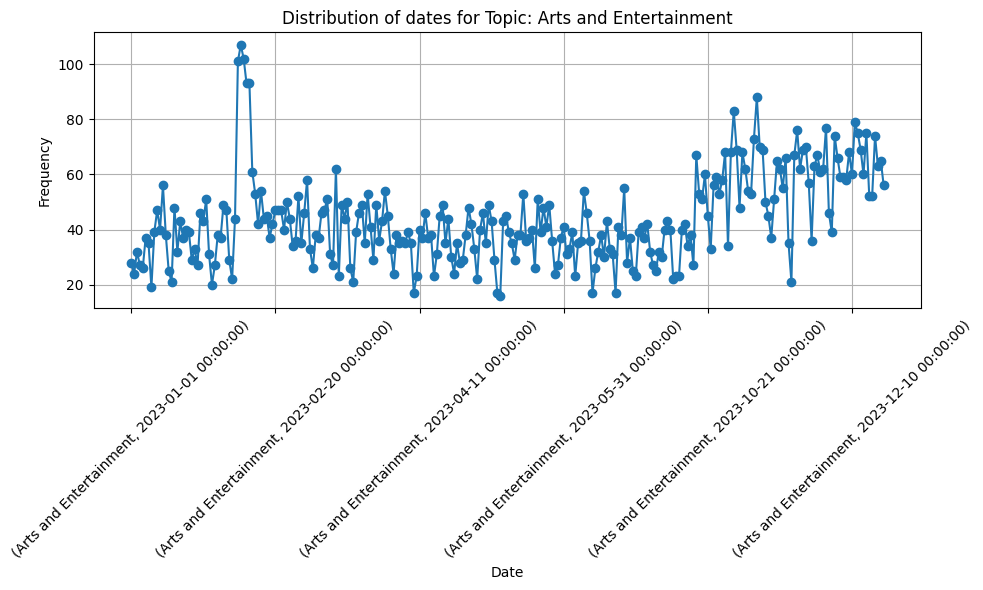

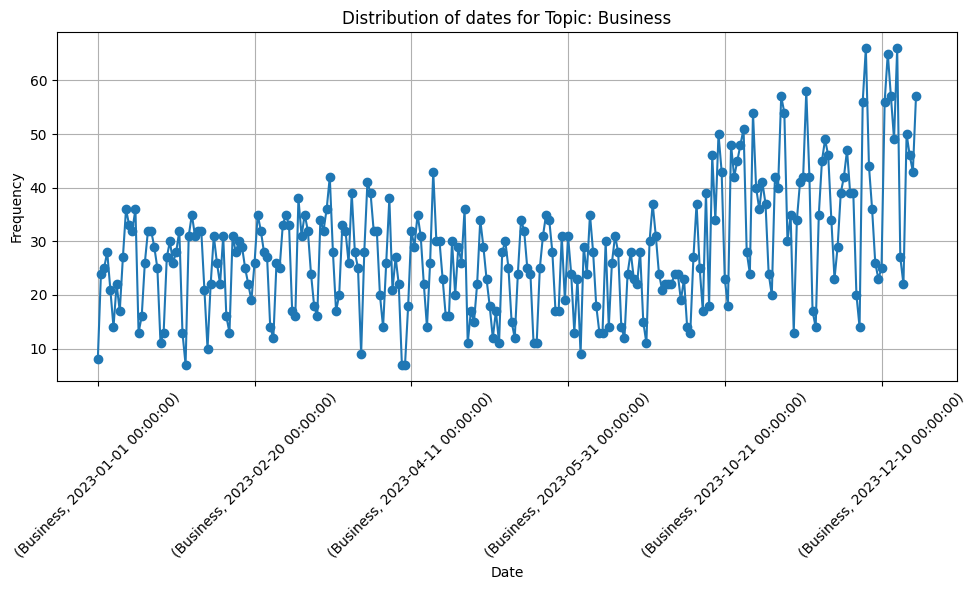

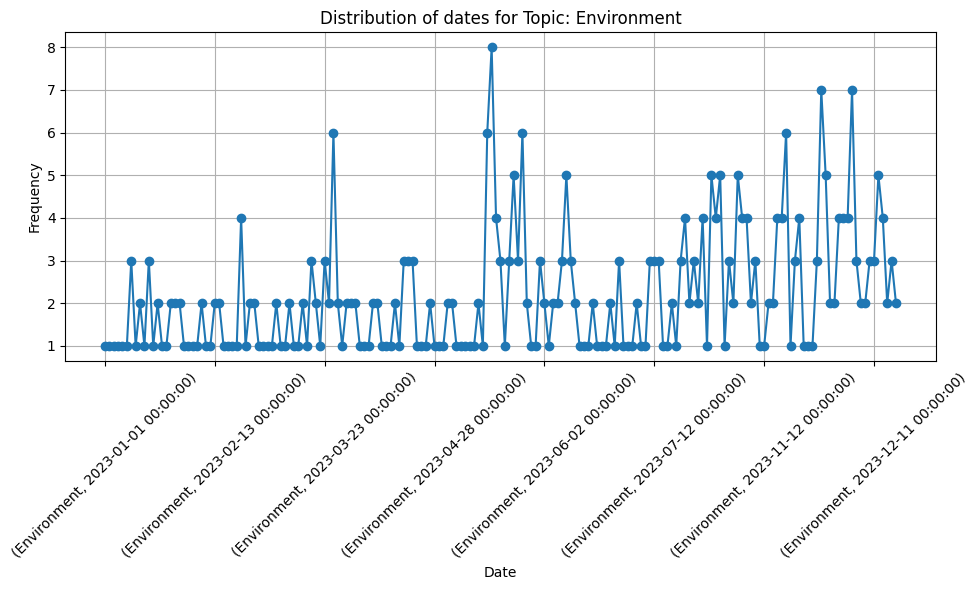

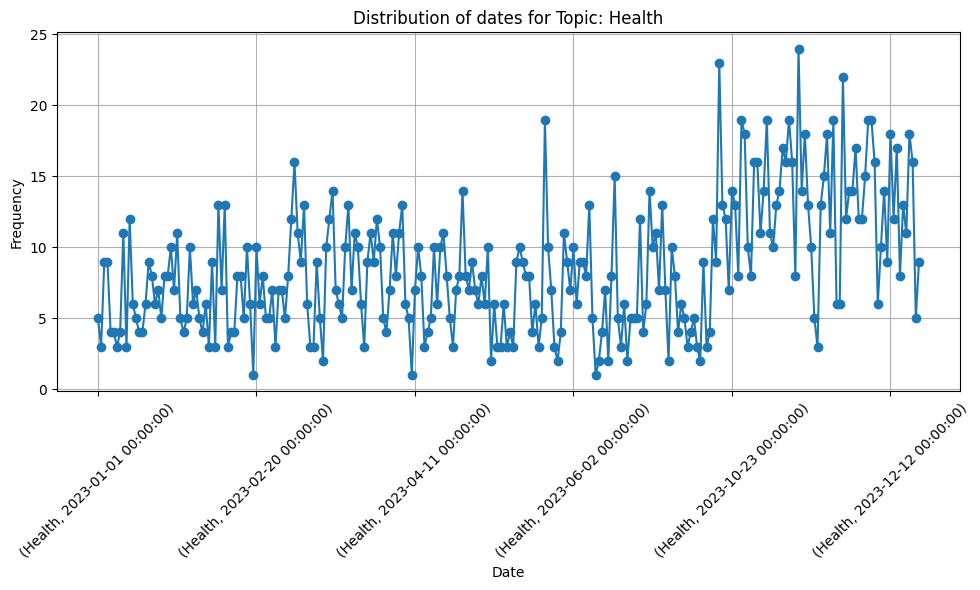

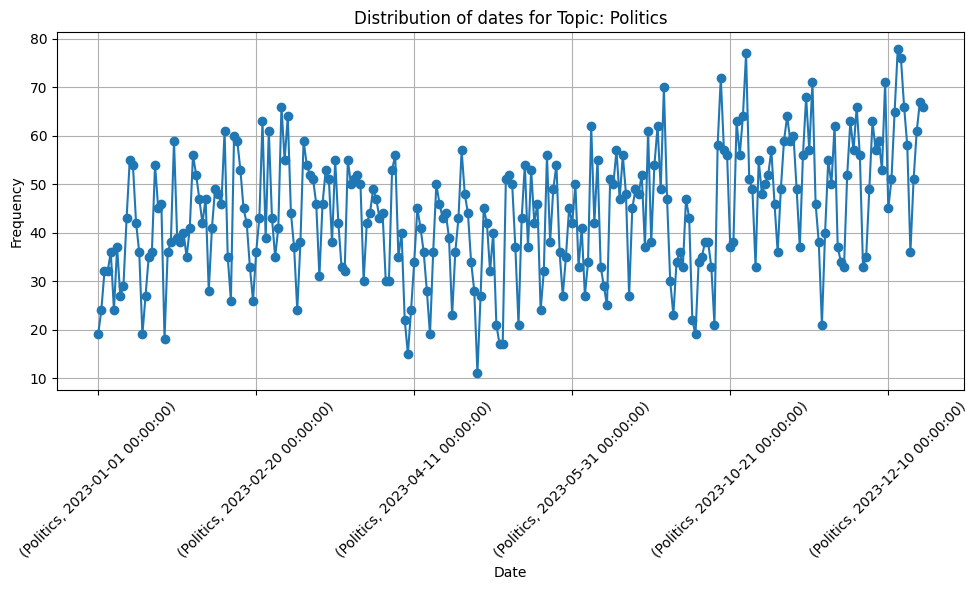

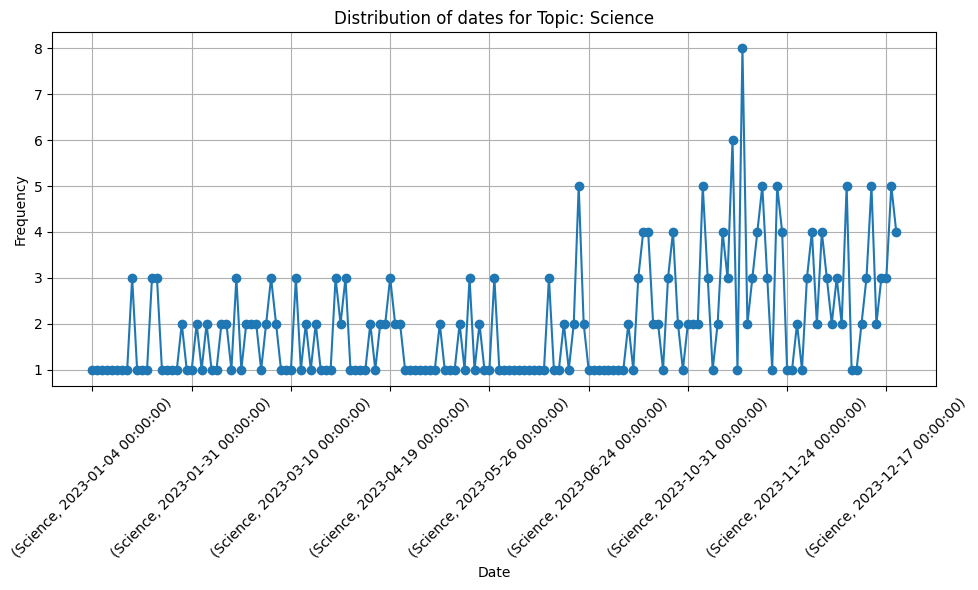

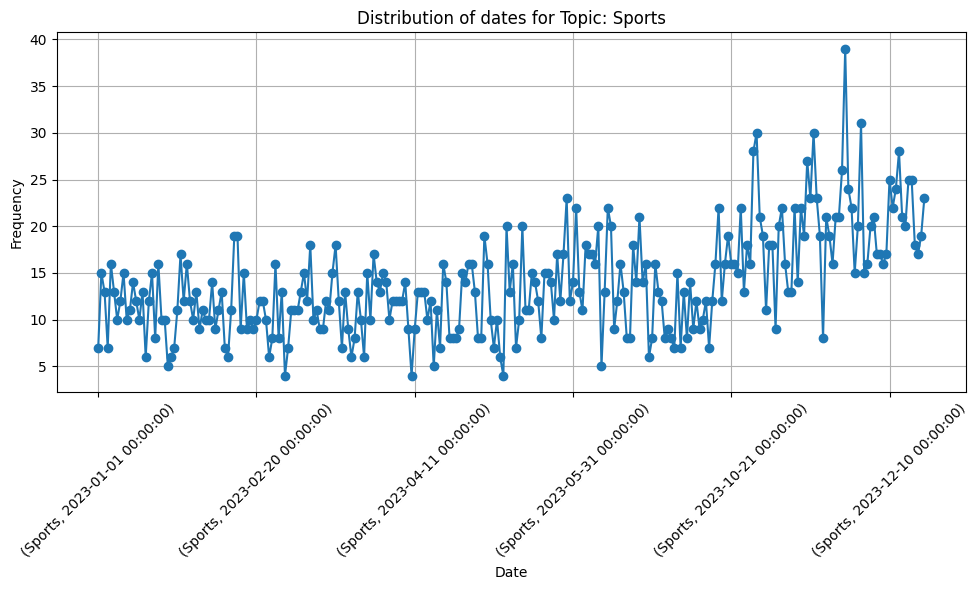

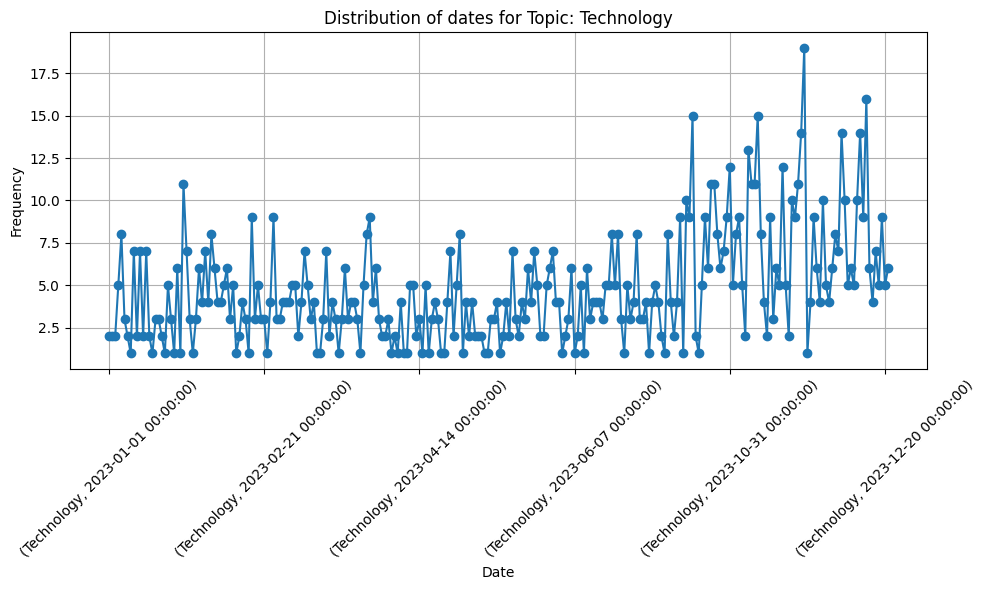

In [15]:
import matplotlib.pyplot as plt

# Assuming df_2023 is your DataFrame containing data for the year 2023
# Assuming 'topic' is the name of the column containing topics and 'date_column' is the name of the column containing dates

# Convert the date_column to datetime data type if not already done
df_2023_cl['date_column'] = pd.to_datetime(df_2023_cl['date_column'])

# Group the DataFrame by 'topic' and aggregate the dates
topic_date_distribution = df_2023_cl.groupby('topic')['date_column'].value_counts()

# Order the series by date
topic_date_distribution = topic_date_distribution.sort_index(level='date_column')

# Plot the distribution for each topic
for topic, distribution in topic_date_distribution.groupby(level=0):
    plt.figure(figsize=(10, 6))
    distribution.plot(kind='line', marker='o')
    plt.title(f'Distribution of dates for Topic: {topic}')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd

# Sort the DataFrame by date
df_sorted = df_2023_cl.sort_values(by='date_column')

# Group the DataFrame by topic
grouped = df_sorted.groupby('topic')

# Define a function to assign labels based on date ranges
def assign_labels(group):
    total_count = len(group)
    train_count = int(0.95 * total_count)  # 95% of observations for TRAIN
    validate_test_count = (total_count - train_count) // 2  # Remaining observations for VALIDATE and TEST

    # Assign labels based on date ranges
    group.loc[group.index[:train_count], 'split'] = 'TRAIN'
    group.loc[group.index[train_count:train_count + validate_test_count], 'split'] = 'VALIDATE'
    group.loc[group.index[train_count + validate_test_count:], 'split'] = 'TEST'
    
    return group['split']  # Return the 'split' column as a Series

# Apply the function to each group and concatenate the results
split_series = pd.concat([assign_labels(group) for _, group in grouped])

# Assign the resulting Series to a new column in the original DataFrame
df_2023_cl['split'] = split_series


In [17]:
# Define a function to calculate the date range
def date_range(group):
    min_date = group['date'].min()
    max_date = group['date'].max()
    return min_date, max_date

# Group by topic and split, and apply the date_range function
date_ranges = df_2023_cl.groupby(['topic', 'split']).apply(date_range)

# Print the result
for (topic, split), (min_date, max_date) in date_ranges.items():
    print(f"Topic: {topic}, Split: {split}, Date Range: {min_date} - {max_date}")

Topic: Arts and Entertainment, Split: TEST, Date Range: 2023-12-17 00:00:00 - 2023-12-21 00:00:00
Topic: Arts and Entertainment, Split: TRAIN, Date Range: 2023-01-01 00:00:00 - 2023-12-12 00:00:00
Topic: Arts and Entertainment, Split: VALIDATE, Date Range: 2023-12-12 00:00:00 - 2023-12-17 00:00:00
Topic: Business, Split: TEST, Date Range: 2023-12-18 00:00:00 - 2023-12-21 00:00:00
Topic: Business, Split: TRAIN, Date Range: 2023-01-01 00:00:00 - 2023-12-13 00:00:00
Topic: Business, Split: VALIDATE, Date Range: 2023-12-13 00:00:00 - 2023-12-18 00:00:00
Topic: Environment, Split: TEST, Date Range: 2023-12-14 00:00:00 - 2023-12-20 00:00:00
Topic: Environment, Split: TRAIN, Date Range: 2023-01-01 00:00:00 - 2023-12-10 00:00:00
Topic: Environment, Split: VALIDATE, Date Range: 2023-12-10 00:00:00 - 2023-12-14 00:00:00
Topic: Health, Split: TEST, Date Range: 2023-12-17 00:00:00 - 2023-12-21 00:00:00
Topic: Health, Split: TRAIN, Date Range: 2023-01-01 00:00:00 - 2023-12-12 00:00:00
Topic: Health

/var/tmp/ipykernel_886510/4278780745.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_ranges = df_2023_cl.groupby(['topic', 'split']).apply(date_range)


In [18]:
# Count the number of different splits for each topic
split_counts = df_2023_cl.groupby('topic')['split'].value_counts()

# Print the result
print(split_counts)


topic                   split   
Arts and Entertainment  TRAIN       10935
                        TEST          288
                        VALIDATE      288
Business                TRAIN        7022
                        TEST          185
                        VALIDATE      185
Environment             TRAIN         371
                        TEST           10
                        VALIDATE       10
Health                  TRAIN        2109
                        TEST           56
                        VALIDATE       56
Politics                TRAIN       10958
                        TEST          289
                        VALIDATE      288
Science                 TRAIN         301
                        TEST            8
                        VALIDATE        8
Sports                  TRAIN        3451
                        TEST           91
                        VALIDATE       91
Technology              TRAIN        1141
                        TEST           31
 

In [19]:
### downsample

In [20]:
# Filter the DataFrame to include only "TRAIN" observations
train_df = df_2023_cl[df_2023_cl['split'] == 'TRAIN']

In [21]:
# Downsample the "TRAIN" section
minority_class_size = min(train_df['topic'].value_counts())
downsampled_train_df = train_df.reset_index(drop=True).groupby('topic').apply(lambda x: x.sample(minority_class_size)).reset_index(drop=True)

print(downsampled_train_df['topic'].value_counts())

topic
Arts and Entertainment    301
Business                  301
Environment               301
Health                    301
Politics                  301
Science                   301
Sports                    301
Technology                301
Name: count, dtype: int64


/var/tmp/ipykernel_886510/2746646605.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  downsampled_train_df = train_df.reset_index(drop=True).groupby('topic').apply(lambda x: x.sample(minority_class_size)).reset_index(drop=True)


In [22]:
# Concatenate downsampled DataFrames for "TEST" and "VALIDATION" splits
final_df = pd.concat([downsampled_train_df, df_2023_cl[df_2023_cl['split'] == 'VALIDATE'], df_2023_cl[df_2023_cl['split'] == 'TEST']])
final_df.reset_index(drop=True)
print(final_df['split'].value_counts())

split
TRAIN       2408
TEST         958
VALIDATE     956
Name: count, dtype: int64


In [23]:
nan_count = final_df.isna().sum()
print("Total NaN values:", nan_count)

Total NaN values: uri                       0
url                       0
title                     0
body                      0
date                      0
time                      0
dateTime                  0
dateTimePub               0
lang                      0
isDuplicate               0
dataType                  0
sentiment              4322
eventUri               2788
relevance                 0
image                    14
authors                   0
sharesFacebook            0
sourceTitle               0
sourceLocationLabel      34
categoryLabels            0
categoryWeights           0
importanceRank            0
alexaGlobalRank           0
alexaCountryRank          0
date_column               0
year                      0
month                     0
topic                     0
split                     0
dtype: int64


In [24]:
nan_count = final_df.isna().sum()
print("Total NaN values:", nan_count)

Total NaN values: uri                       0
url                       0
title                     0
body                      0
date                      0
time                      0
dateTime                  0
dateTimePub               0
lang                      0
isDuplicate               0
dataType                  0
sentiment              4322
eventUri               2788
relevance                 0
image                    14
authors                   0
sharesFacebook            0
sourceTitle               0
sourceLocationLabel      34
categoryLabels            0
categoryWeights           0
importanceRank            0
alexaGlobalRank           0
alexaCountryRank          0
date_column               0
year                      0
month                     0
topic                     0
split                     0
dtype: int64


In [25]:
from sklearn.preprocessing import RobustScaler
# Create a RobustScaler object
scaler = RobustScaler()

# If you want to apply it to a DataFrame column:
final_df['shares_scaled'] = scaler.fit_transform(final_df['sharesFacebook'].values.reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


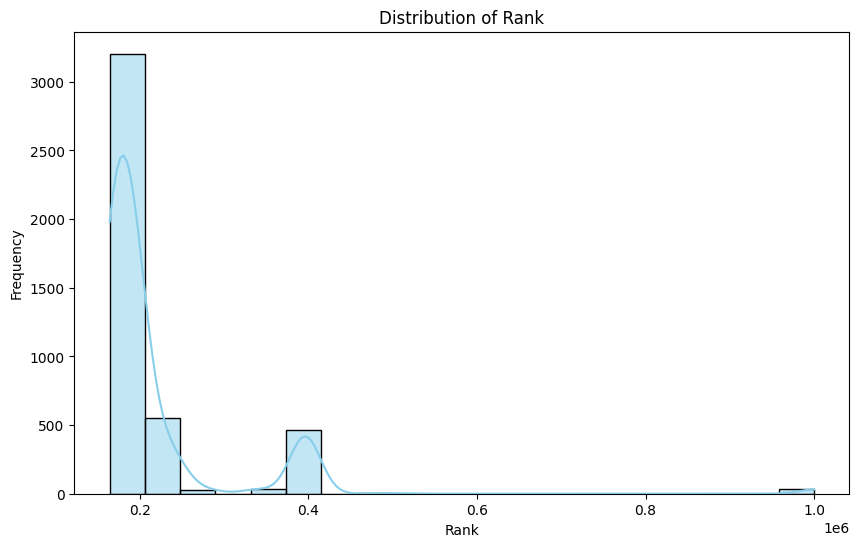

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the "rank" column
plt.figure(figsize=(10, 6))
sns.histplot(final_df['importanceRank'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Rank')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


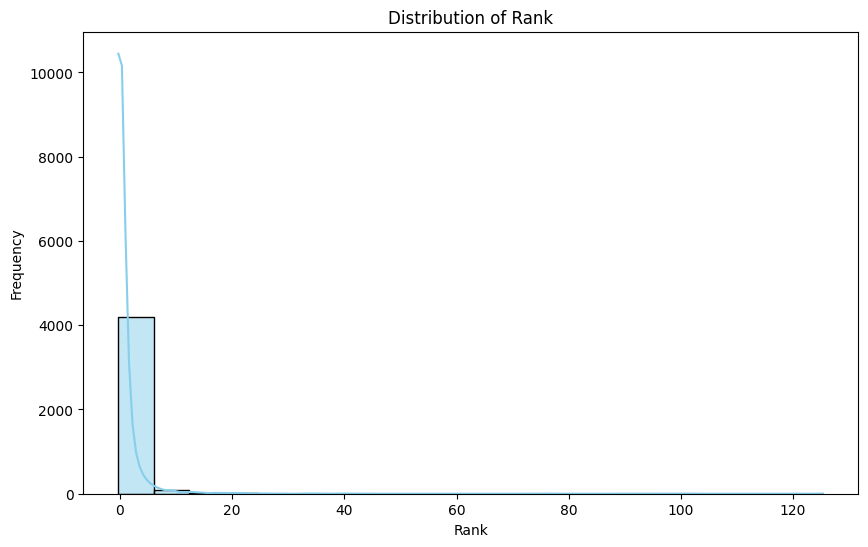

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the "rank" column
plt.figure(figsize=(10, 6))
sns.histplot(final_df['shares_scaled'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Rank')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

### Salvo il DF to parquet

In [33]:
### Salvo il df come parquet to the bucket
bucket_name="ccai-storage"

folder = "pipeline"
# Define your Google Cloud Storage bucket name and Parquet file name
parquet_file_name = 'final_df.parquet'

# Save DataFrames to GCS as Parquet files in the 'fabio' folder
save_df_to_gcs_parquet(final_df, bucket_name, folder, parquet_file_name)

#df_no_dups_test
# Remove the local Parquet file
# os.remove(parquet_file_name)

In [ ]:
### Sentiment

In [ ]:
import pandas as pd
from google.cloud import language_v1
import json

def analyze_text_sentiment(df: pd.DataFrame, text_column: str = 'preprocessed_text', num_documents: int = 10) -> pd.DataFrame:
    client = language_v1.LanguageServiceClient()

    data = []

    for i, row in df.head(num_documents).iterrows():
        text = row[text_column]
        document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
        response = client.analyze_sentiment(request={'document': document})

        # Append sentiment analysis results to the data list
        data.append({
            **row.to_dict(),  # Keep other features in the row
            'score': response.document_sentiment.score,
            'magnitude': response.document_sentiment.magnitude
        })

    return pd.DataFrame(data)

row_count = len(final_df)

# Example usage:
# Assuming df is your pandas DataFrame with a 'preprocessed_text' column and other features
df_sentiment = analyze_text_sentiment(final_df, text_column='body', num_documents=row_count)


### Salvo il df come parquet to the bucket
bucket_name="fabiopnlp"

folder = "pipeline"
# Define your Google Cloud Storage bucket name and Parquet file name
parquet_file_name = 'final_df5_sent_ita.parquet'

# Save DataFrames to GCS as Parquet files in the 'fabio' folder
save_df_to_gcs_parquet(df_sentiment, bucket_name, folder, parquet_file_name)

#df_no_dups_test
# Remove the local Parquet file
# os.remove(parquet_file_name)


In [61]:
# Carica l'elenco delle stopwords
stop_words = set(stopwords.words('italian'))

# Definisci una funzione per rimuovere le stopwords e la punteggiatura
def preprocess_title(text):

    # Tokenizza il testo
    tokens = nltk.word_tokenize(text)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rimuovi le stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Join tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

# Applica la funzione remove_stopwords_and_punct alla colonna preprocessed_text del tuo DataFrame
final_df.loc[:,'body_pre'] = final_df['body'].apply(preprocess_title)


In [63]:
final_df

,url,title,body,date,time,dateTime,dateTimePub,lang,isDuplicate,dataType,...,alexaGlobalRank,alexaCountryRank,date_column,year,month,year_month,topic,split,shares_scaled,body_pre
0,https://www.fanpage.it/spettacolo/personaggi/a...,Arrestato Nathan Chasing Horse di Balla coi lu...,"Nathan Lee Chasing, meglio conosciuto come Nat...",2023-02-01,10:43:00,2023-02-01T10:43:00Z,2023-02-01T10:37:00Z,ita,False,news,...,10261,68,2023-02-01,2023,2,2023-2,Arts and Entertainment,TRAIN,1.857143,"Nathan Lee Chasing , meglio conosciuto Nathan ..."
1,https://www.ilrestodelcarlino.it/cronaca/i-min...,"I minori e i reati sessuali: ""Un boom preoccup...",Allarme del pg di Ancona: sempre più ragazzini...,2023-12-06,08:08:48,2023-12-06T08:08:48Z,2023-12-06T07:49:32Z,ita,False,news,...,57981,822,2023-12-06,2023,12,2023-12,Arts and Entertainment,TRAIN,-0.071429,Allarme pg Ancona : sempre ragazzini commetton...
2,https://www.ilfattoquotidiano.it/2023/08/08/wi...,"William Friedkin morto, quando muore un regist...",Quando a lasciarci è un signore come William F...,2023-08-08,14:26:36,2023-08-08T14:26:36Z,2023-08-08T14:24:09Z,ita,False,news,...,3336,47,2023-08-08,2023,8,2023-8,Arts and Entertainment,TRAIN,1.571429,Quando lasciarci signore William Friedkin biso...
3,https://www.fanpage.it/spettacolo/eventi/tanan...,Tananai al Love Mi scende nel pubblico e non s...,"Tananai, all'anagrafe Alberto Cotta Ramusino, ...",2023-06-28,06:19:00,2023-06-28T06:19:00Z,2023-06-28T06:17:00Z,ita,False,news,...,10261,68,2023-06-28,2023,6,2023-6,Arts and Entertainment,TRAIN,3.071429,"Tananai , all'anagrafe Alberto Cotta Ramusino ..."
4,https://www.tgcom24.mediaset.it/donne/oroscopo...,Oroscopo: scopri quanto sei aperto al cambiame...,ARIETE\n\nNon sempre vai a caccia di grandi ca...,2023-03-06,07:28:00,2023-03-06T07:28:00Z,2023-03-06T07:27:00Z,ita,False,news,...,1969,28,2023-03-06,2023,3,2023-3,Arts and Entertainment,TRAIN,2.000000,ARIETE sempre vai caccia grandi cambiamenti vi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102073,https://www.lastampa.it/editoriali/lettere-e-i...,Una storia poco Chiara,"John Paul Getty, miliardario, in casa aveva me...",2023-12-19,00:03:24,2023-12-19T00:03:24Z,2023-12-19T00:00:00Z,ita,False,news,...,5616,91,2023-12-19,2023,12,2023-12,Arts and Entertainment,TEST,0.000000,"John Paul Getty , miliardario , casa messo luc..."
1102074,https://www.lastampa.it/sport/calcio/2023/12/1...,"Massimo Mauro: ""Un anno senza il mio amico Luc...","""No, vai"".\n\n""Va bene, passo il Natale a casa...",2023-12-19,00:03:20,2023-12-19T00:03:20Z,2023-12-19T00:00:00Z,ita,False,news,...,5616,91,2023-12-19,2023,12,2023-12,Sports,TEST,0.142857,"`` No , vai '' . `` Va bene , passo Natale cas..."
1102075,https://www.lastampa.it/cronaca/2023/12/19/new...,"Chiara Ferragni e il caso Balocco: l'errore, l...",L'influencer pubblica un video dopo la multa p...,2023-12-19,00:03:18,2023-12-19T00:03:18Z,2023-12-19T00:00:00Z,ita,False,news,...,5616,91,2023-12-19,2023,12,2023-12,Arts and Entertainment,TEST,0.142857,L'influencer pubblica video dopo multa campagn...
1102076,https://www.lastampa.it/editoriali/lettere-e-i...,Se insieme al Reddito è sparita la formazione,La cancellazione del Reddito di Cittadinanza e...,2023-12-19,00:03:18,2023-12-19T00:03:18Z,2023-12-19T00:00:00Z,ita,False,news,...,5616,91,2023-12-19,2023,12,2023-12,Business,TEST,0.142857,cancellazione Reddito Cittadinanza sostituzion...


In [62]:

### Salvo il df come parquet to the bucket
bucket_name="fabiopnlp"

folder = "pipeline"
# Define your Google Cloud Storage bucket name and Parquet file name
parquet_file_name = 'final_df5_sent_ita_pre.parquet'

# Save DataFrames to GCS as Parquet files in the 'fabio' folder
save_df_to_gcs_parquet(final_df, bucket_name, folder, parquet_file_name)


In [64]:
import pandas as pd
from google.cloud import language_v1
import json

def analyze_text_sentiment(row, text_column: str = 'preprocessed_text', num_documents: int = 10) -> dict:
    client = language_v1.LanguageServiceClient()
    text = row[text_column]
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    response = client.analyze_sentiment(request={'document': document})

    # Restituisce un dizionario con i risultati dell'analisi del sentiment
    return {
        'score': response.document_sentiment.score,
        'magnitude': response.document_sentiment.magnitude,
        'num_documents': num_documents
    }


num_documents=100
# Applica la funzione analyze_text_sentiment a ciascuna riga del DataFrame
sentiment_results = final_df.head(num_documents).apply(lambda row: analyze_text_sentiment(row, text_column='body_pre', num_documents=num_documents), axis=1)

# Crea un DataFrame dai risultati dell'analisi del sentiment
df_sentiment = pd.DataFrame(sentiment_results.tolist())

# Unisce il DataFrame originale con i risultati dell'analisi del sentiment
df_sentiment = pd.concat([final_df.head(num_documents), df_sentiment], axis=1)

### Salvo il df come parquet to the bucket
bucket_name="fabiopnlp"

folder = "pipeline"
# Define your Google Cloud Storage bucket name and Parquet file name
parquet_file_name = 'final_df5_sent_ita.parquet'

# Save DataFrames to GCS as Parquet files in the 'fabio' folder
save_df_to_gcs_parquet(df_sentiment, bucket_name, folder, parquet_file_name)

In [41]:
# Filter the DataFrame to include only "TRAIN" observations
test_df = final_df[final_df['split'] == 'TEST']

In [42]:
# Upload to BQ :        
ds_id = "dataset_nlp"
project = !gcloud config get-value project
PROJECT_ID = project[0]
bucket = 'fabiopnlp'
table_id="final_df5_ita_test"
location = "europe-west3"  # Specify the location where your BigQuery dataset resides
upload_dataframe_to_bigquery(test_df, table_id, PROJECT_ID, ds_id, bucket, location)

Loaded 9395 rows into BigQuery table: indigo-splice-417308.dataset_nlp.final_df5_ita_test


In [39]:
# Upload to BQ :        
ds_id = "dataset_nlp"
project = !gcloud config get-value project
PROJECT_ID = project[0]
bucket = 'fabiopnlp'
table_id="final_df5_ita"
location = "europe-west3"  # Specify the location where your BigQuery dataset resides
upload_dataframe_to_bigquery(final_df, table_id, PROJECT_ID, ds_id, bucket, location)

Loaded 41228 rows into BigQuery table: indigo-splice-417308.dataset_nlp.final_df5_ita
